In [103]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
from tqdm import tqdm

In [104]:
def Greens_free_field(x, y, x0, y0, f, c):
    """Compute the 2D Green's function in free field."""
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    k = 2 * np.pi * f / c
    G = np.exp(-1j * k * r) / (4 * np.pi * r)
    return G

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

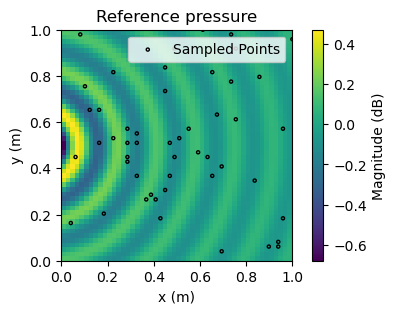

In [ ]:
# Define parameters
c = 343.0
f = 2000.0
Lx, Ly = 1.0, 1.0  
x0, y0 = -0.1, 0.5

# Compute the Green's function on a grid
X, Y = np.meshgrid(np.linspace(0, Lx, int(Lx*50)), np.linspace(0, Ly, int(Ly*50)))
r_rec = np.array([X.flatten(), Y.flatten()]).T
p_ref = Greens_free_field(r_rec[:, 0], r_rec[:, 1], x0, y0, f, c)

# Find indices within a square of length L centered at (Lx/2, Ly/2)
L = 0.2
mask = (
    (np.abs(r_rec[:, 0] - Lx/2) <= L/2) &
    (np.abs(r_rec[:, 1] - Ly/2) <= L/2)
)
indices = np.where(mask)[0]
m = len(indices)
p_obs = p_ref[indices]
p_obs += 0.01 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p_obs)**2))
r = r_rec[indices]

# # Sample m points from the reference pressure
# np.random.seed(42)
# m = 50
# indices = np.random.choice(p_ref.size, m, replace=False)
# p_obs = p_ref[indices]
# p_obs += 0.1 * (np.random.randn(m) + 1j * np.random.randn(m)) * np.sqrt(np.mean(np.abs(p_obs)**2))
# r = r_rec[indices]

# Figure of the reference pressure over space and the sampled points
vmin, vmax = np.min(p_ref.real), np.max(p_ref.real)
fig = plt.figure(figsize=(5, 3))
im = plt.imshow(p_ref.real.reshape(X.shape), extent=(0, Lx, 0, Ly), aspect='equal', cmap='viridis', vmin=vmin, vmax=vmax)
plt.scatter(r[:, 0], r[:, 1], facecolors='none', edgecolors='black', s=5, label='Sampled Points')
plt.legend(loc='upper right')
fig.colorbar(im, label='Magnitude (dB)')
plt.title('Reference pressure')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [106]:
n_in = 2
n_out = 2
n_hidden = 32
n_layers = 3
n_epochs = int(1e4)

r = torch.tensor(r, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs, dtype=torch.complex64).requires_grad_(True)
r_rec = torch.tensor(r_rec, dtype=torch.float32).requires_grad_(True)

model = FCN(n_in, n_out, n_hidden, n_layers)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model(r)
    loss = mse_loss(p[:, 0], p_obs.real) + mse_loss(p[:, 1], p_obs.imag)

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())


100%|██████████| 10000/10000 [00:22<00:00, 446.65it/s]


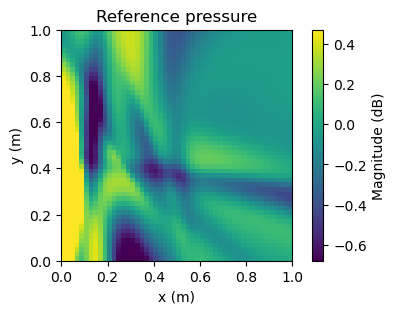

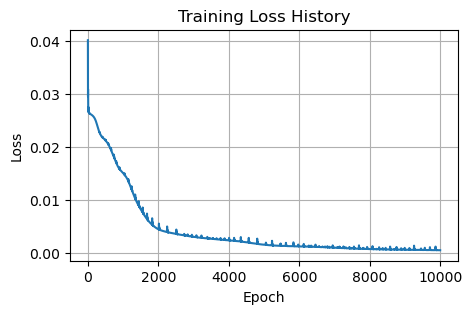

In [107]:
p_rec = model(r_rec).detach().numpy()

fig = plt.figure(figsize=(5, 3))
im = plt.imshow(p_rec[:,0].reshape(X.shape), extent=(0, Lx, 0, Ly), aspect='equal', cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, label='Magnitude (dB)')
plt.title('Reference pressure')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

In [108]:
def pde_residual(p, r, k):
    p_r = torch.autograd.grad(p, r, torch.ones_like(p), create_graph=True)[0]
    p_xx = torch.autograd.grad(p_r[:,0], r, torch.ones_like(p_r[:,0]), create_graph=True)[0][:,0:1]
    p_yy = torch.autograd.grad(p_r[:,1], r, torch.ones_like(p_r[:,1]), create_graph=True)[0][:,1:2]
    pde_res = p_xx + p_yy + p*k**2
    return pde_res

k = 2 * np.pi * f / c
alpha = 1e6
model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

n_epochs = int(1e4)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    
    p = model_pinn(r)
    loss_obs = alpha*(mse_loss(p[:, 0], p_obs.real) + mse_loss(p[:, 1], p_obs.imag))

    r_collocation = torch.randn_like(r, dtype=torch.float32, requires_grad=True) * torch.tensor([Lx, Ly])
    p = model_pinn(r_collocation)
    p_complex = p[:, 0] + 1j * p[:, 1]
    loss_pde = torch.mean(torch.abs(pde_residual(p_complex, r_collocation, k)**2))

    loss = loss_obs + loss_pde

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())



100%|██████████| 10000/10000 [01:44<00:00, 96.00it/s]


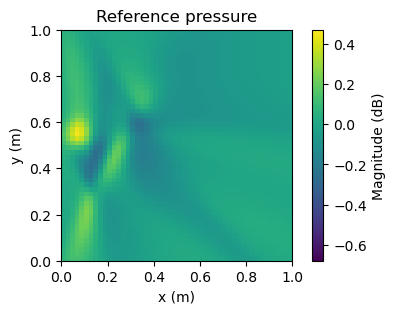

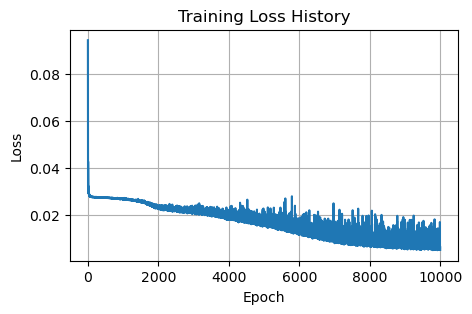

In [109]:
p_rec = model_pinn(r_rec).detach().numpy()

fig = plt.figure(figsize=(5, 3))
im = plt.imshow(p_rec[:,0].reshape(X.shape), extent=(0, Lx, 0, Ly), aspect='equal', cmap='viridis', vmin=vmin, vmax=vmax)
# plt.scatter(r[:, 0], r[:, 1], facecolors='none', edgecolors='black', s=5, label='Sampled Points')
# plt.legend(loc='upper right')
fig.colorbar(im, label='Magnitude (dB)')
plt.title('Reference pressure')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history) / alpha)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()